In [58]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
spark

In [59]:
# data = spark.read.csv("./sample_data - one_year.csv", header=True)
data = spark.read.csv("./sample_data - one_year.csv", header=True, inferSchema=True)

In [60]:
# if we prepare working with sql
data.createTempView("vw_dataset")

AnalysisException: [TEMP_TABLE_OR_VIEW_ALREADY_EXISTS] Cannot create the temporary view `vw_dataset` because it already exists.
Choose a different name, drop or replace the existing view,  or add the IF NOT EXISTS clause to tolerate pre-existing views.

# Understand dataset

In [12]:
data.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: boolean (nullable = true)
 |-- monthly_income: double (nullable = true)
 |-- emp_industry: string (nullable = true)
 |-- age: integer (nullable = true)



## Get a few row

### By dataframe python api

In [13]:
data.show(2)

+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|annual_inc|issue_d|loan_status|    monthly_income|emp_industry|age|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|     5000| 36 months|   13.56|     169.83|    C|       C1|Public Affairs Sp...| 10+ years|  175000.0| Aug-18|      false|14583.333333333334|       other| 33|
|     4000| 36 months|    10.9|     130.77|    B|       B4|     Reception/Sales|    1 year|   25000.0| Mar-18|       true|2083.3333333333335|       other| 21|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
only showing top 2 rows



### By Spark SQL

In [26]:
spark.sql("select * from vw_dataset limit 2").show();

+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|annual_inc|issue_d|loan_status|    monthly_income|emp_industry|age|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|     5000| 36 months|   13.56|     169.83|    C|       C1|Public Affairs Sp...| 10+ years|  175000.0| Aug-18|      false|14583.333333333334|       other| 33|
|     4000| 36 months|    10.9|     130.77|    B|       B4|     Reception/Sales|    1 year|   25000.0| Mar-18|       true|2083.3333333333335|       other| 21|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+



## Get a few columns

### By dataframe python api

In [21]:
data.select("loan_amnt", "term").show(10)

+---------+----------+
|loan_amnt|      term|
+---------+----------+
|     5000| 36 months|
|     4000| 36 months|
|     5000| 36 months|
|     5500| 36 months|
|    11200| 60 months|
|    36000| 60 months|
|    21925| 36 months|
|    10000| 36 months|
|     7925| 36 months|
|    10000| 36 months|
+---------+----------+
only showing top 10 rows



### By Spark SQL

In [33]:
df = spark.sql("select loan_amnt, term from vw_dataset")

In [36]:
df.select("*").show(2)

+---------+----------+
|loan_amnt|      term|
+---------+----------+
|     5000| 36 months|
|     4000| 36 months|
+---------+----------+
only showing top 2 rows



# Analyse data

## Loan group

In [54]:
from pyspark.sql.functions import when
new_df = data.withColumn("loan_group", when(data.loan_amnt > 5000, "big amount").otherwise("small amount"))

In [56]:
new_df.select("loan_group", "loan_amnt").groupby('loan_group').count().show()

+------------+-----+
|  loan_group|count|
+------------+-----+
|small amount| 6513|
|  big amount|43011|
+------------+-----+



<Axes: ylabel='Frequency'>

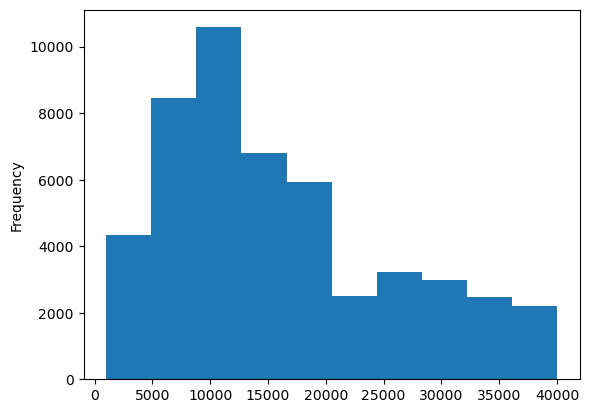

In [64]:
new_df.toPandas()['loan_amnt'].plot.hist()

In [66]:
new_df.toPandas()['loan_amnt'].plot()

AttributeError: 'PlotAccessor' object has no attribute 'violin'

# If prefer to work with pandas

In [50]:
data.to_pandas_on_spark()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pyspark/sql/dataframe.py:5723: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,issue_d,loan_status,monthly_income,emp_industry,age
0,5000,36 months,13.56,169.83,C,C1,Public Affairs Specialist,10+ years,175000.00,Aug-18,False,14583.333333,other,33
1,4000,36 months,10.90,130.77,B,B4,Reception/Sales,1 year,25000.00,Mar-18,True,2083.333333,other,21
2,5000,36 months,23.40,194.60,E,E1,Sales,7 years,120000.00,Jul-18,True,10000.000000,other,56
3,5500,36 months,14.47,189.24,C,C2,other,None,26300.00,Dec-18,False,2191.666667,other,20
4,11200,60 months,16.14,273.20,C,C4,Engeneering,1 year,35000.00,Aug-18,True,2916.666667,other,23
5,36000,60 months,15.04,857.20,C,C4,Logistics Coordinator,10+ years,65000.00,May-18,True,5416.666667,other,48
6,21925,36 months,10.91,716.87,B,B4,Senior Supervisor,8 years,152000.00,Feb-18,True,12666.666667,other,58
7,10000,36 months,18.45,363.79,D,D2,Customer service,< 1 year,32000.00,Jun-18,True,2666.666667,other,24
8,7925,36 months,16.91,282.20,C,C5,station agent,10+ years,50000.00,Dec-18,False,4166.666667,other,34
9,10000,36 months,14.08,342.17,C,C3,Cook,10+ years,35000.00,Feb-18,True,2916.666667,other,24
